# Market Attribution Channels using Markov Chains

In [21]:
# Importing libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess

In [23]:
# Loading and sorting the data
df = pd.read_csv('attribution data.csv')
cols = df.columns
for col in cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].map(lambda x: str(x)[:-2] if '.' in x else str(x))

In [24]:
# Formatting the data to get a single row per user
df['Path'] = ''
for i in df.index:
    #df.at[i, 'Path'] = 'Start'
    for x in cols:
        df.at[i, 'Path'] = df.at[i, 'Path'] + df.at[i, x] + ' > '
        
#separating conversion from the path
df['Path'] = df['Path'].map(lambda x: x.split(' > 21')[0])
df['Conversion'] = 1


In [25]:
# Grouping by unique user journeys
# Select relevant columns
df = df[['Path', 'Conversion']]

# Sum conversions by Path
df = df.groupby('Path').sum().reset_index()

# Writing DF to CSV to be executed in R 'ChannelAttribution' library
df.to_csv('Paths.csv', index=False)

In [28]:
# Using R script 
subpath = "C:\\Users\\johne\\Desktop\\Python Projects\\Markov Marketing\\Markov.R"
subprocess.call(['Rscript', '--vanilla', subpath], shell=True)

1

In [38]:
# Load in the CSV file with the model output from R
markov = pd.read_csv('Markov - Output - Conversion values.csv')

# Select only the necessary columns and rename them
markov = markov[['channel_name', 'total_conversions']]
markov.columns = ['Channel', 'Conversion']

In [39]:
markov.head()

,Channel,Conversion
0,00000FkCnDfDDf0iC97iC703B,0.789224
1,2018-07-03T13:02:11Z,0.248827
2,impression,195.878600
3,0,195.878600
4,Instagram,24.435403


In [46]:
markov['Channel'] = markov['Channel'].unique()
markov.sort_values(by='Conversion', ascending=False, inplace=True)
markov.head()

,Channel,Conversion
2,impression,195.878600
3,0,195.878600
11,Paid Search,56.705034
30,Facebook,51.647591
45,Online Video,44.981170


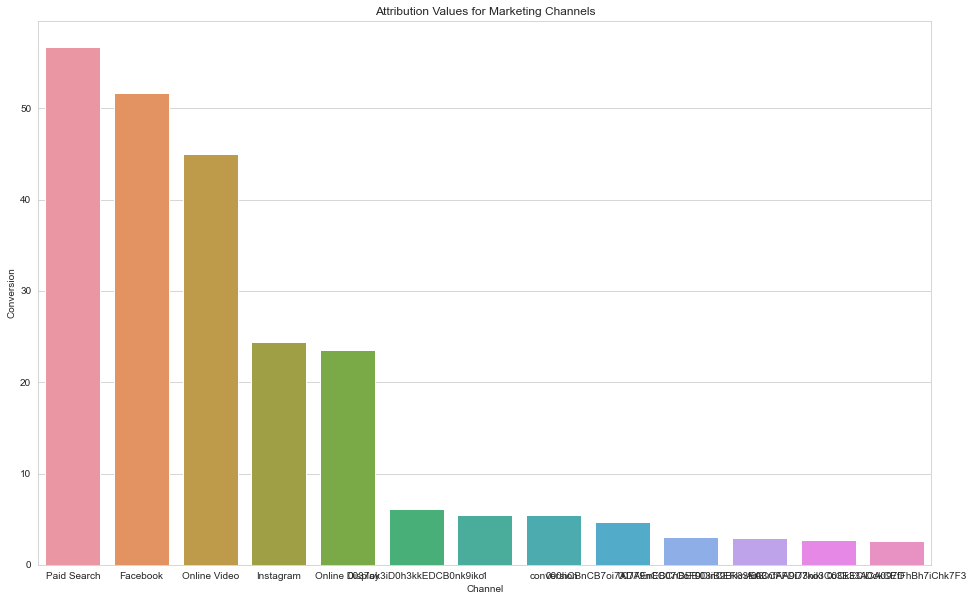

In [57]:
sns.set_style("whitegrid")
plt.rc('legend', fontsize=15)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='Channel', y='Conversion', data=markov[2:15]) # 0 and 1 columns are redundant
plt.title('Attribution Values for Marketing Channels')
plt.show()

The Markov-chain model shows that 'paid search' is the channel with the highest conversion rate. 

In [58]:
# Comparing this to First- touch, Last-touch, Linear Attribution

# First Touch Attribution
df['First Touch'] = df['Path'].map(lambda x: x.split(' > ')[0])
df_ft = pd.DataFrame()
df_ft['Channel'] = df['First Touch']
df_ft['Attribution'] = 'First Touch'
df_ft['Conversion'] = 1
df_ft = df_ft.groupby(['Channel', 'Attribution']).sum().reset_index()

# Last Touch Attribution
df['Last Touch'] = df['Path'].map(lambda x: x.split(' > ')[-1])
df_lt = pd.DataFrame()
df_lt['Channel'] = df['Last Touch']
df_lt['Attribution'] = 'Last Touch'
df_lt['Conversion'] = 1
df_lt = df_lt.groupby(['Channel', 'Attribution']).sum().reset_index()

# Linear Attribution
channel = []
conversion = []
for i in df.index:
    for j in df.at[i, 'Path'].split(' > '):
        channel.append(j)
        conversion.append(1/len(df.at[i, 'Path'].split(' > ')))
lin_att_df = pd.DataFrame()
lin_att_df['Channel'] = channel
lin_att_df['Attribution'] = 'Linear'
lin_att_df['Conversion'] = conversion
lin_att_df = lin_att_df.groupby(['Channel', 'Attribution']).sum().reset_index()

In [157]:
markov['Attribution'] = 'Markov'
df_total_attr = pd.concat([df_ft, df_lt, lin_att_df, markov])

## NORMALIZING THE CONVERSION VALUES
normalized_df=(df_total_attr['Conversion']-df_total_attr['Conversion'].min())/(df_total_attr['Conversion'].max()-df_total_attr['Conversion'].min())
df_total_attr['Normalized Values'] = normalized_df

df_total_attr.sort_values(by='Channel', ascending=True, inplace=True)


In [158]:
df_total_attr.head()

,Channel,Attribution,Conversion,Normalized Values
0,,Linear,83227.428571,0.142857
0,,Last Touch,582592.000000,1.000000
3,0,Markov,195.878600,0.000336
1,0,Linear,161415.142859,0.277064
0,00000FkCnDfDDf0iC97iC703B,Markov,0.789224,0.000001


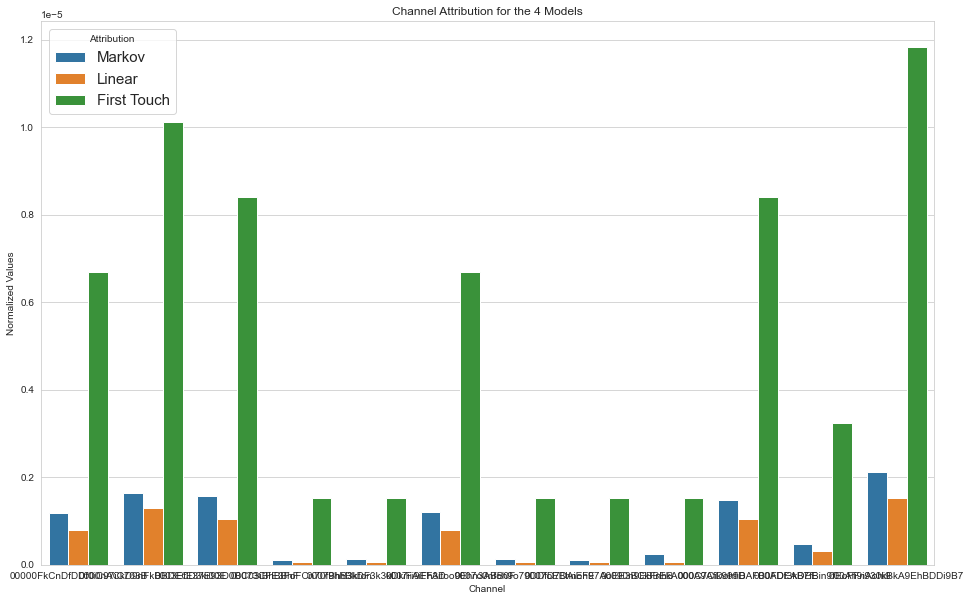

In [171]:
sns.set_style("whitegrid")
plt.rc('legend', fontsize=15)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='Channel', y='Normalized Values', hue='Attribution', data=df_total_attr[4:40])
plt.title('Channel Attribution for the 4 Models')
plt.show()

From here, we can see where the models agree there is the highest conversion rating for a certain attribution channel. 

We can use this data to observe the trend between first, last touch... Where resources can be best allocated towards a certain channel.

Markov - chains provide a great snapshot to channel attribution, which can give a marketing campaign key inisght before a launch. 